<a href="https://colab.research.google.com/github/sarah1ibrahim/End-to-End-Echocardiographic-Analysis-Pipeline/blob/main/Echonet_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First 50 videos in alphanumeric order assuming smaller frame number is ES and the larger frame number is ED

In [ ]:
# Uninstall existing packages
!pip uninstall -y timm pretrained-backbones-unet

# Install pretrained-backbones-unet without dependencies
!pip install pretrained-backbones-unet --no-deps

# Install a compatible version of timm
!pip install timm==0.9.12


Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
# Verify installations
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
from backbones_unet.model.unet import Unet  # Use pretrained-backbones-unet
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate
import logging
from datetime import datetime
from google.colab import drive


timm version: 0.9.12
Unet imported successfully!


In [ ]:
# Set up logging
log_dir = "/content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"test_unet_masktracings_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(file_formatter)
logger.addHandler(file_handler)

console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_formatter = logging.Formatter('%(message)s')
console_handler.setFormatter(console_formatter)
logger.addHandler(console_handler)

# Remove existing mount point if it exists and is not empty
if os.path.exists('/content/drive'):
    logger.info("Removing existing /content/drive directory...")
    !rm -rf /content/drive
    logger.info("Existing /content/drive directory removed.")

# Mount Google Drive
logger.info("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
logger.info("Google Drive mounted successfully.")


INFO:root:Removing existing /content/drive directory...
Removing existing /content/drive directory...
INFO:root:Existing /content/drive directory removed.
Existing /content/drive directory removed.
INFO:root:Mounting Google Drive...
Mounting Google Drive...
INFO:root:Google Drive mounted successfully.
Google Drive mounted successfully.


Mounted at /content/drive


In [ ]:
# @title
# Constants
NUM_CLASSES = 4  # Model was trained with 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
CSV_PATH = "/content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Directories to save predicted masks (optional)
SAVE_PREDICTIONS = False  # Set to True to save predicted masks
ED_PREDICTIONS_PATH = os.path.join(log_dir, "ED_Predictions")
ES_PREDICTIONS_PATH = os.path.join(log_dir, "ES_Predictions")
if SAVE_PREDICTIONS:
    os.makedirs(ED_PREDICTIONS_PATH, exist_ok=True)
    os.makedirs(ES_PREDICTIONS_PATH, exist_ok=True)


In [ ]:
# Instantiate the model with a pretrained backbone
model = Unet(
    backbone='convnext_base',  # Matches training
    in_channels=3,            # Trained with 3 channels (RGB)
    num_classes=NUM_CLASSES   # Keep as 4 to match training
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    logger.info("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    logger.error(f"Failed to load model weights: {e}")
    raise

# Load the CSV file
logger.info(f"Loading CSV file from {CSV_PATH}...")
try:
    df = pd.read_csv(CSV_PATH)
    logger.info("Successfully loaded CSV file.")
except Exception as e:
    logger.error(f"Failed to load CSV file: {e}")
    raise

# Clean video names by removing .avi extension
df['FileName'] = df['FileName'].str.replace('.avi', '')

# Group data by FileName to get frame numbers
grouped = df.groupby("FileName")


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnext_base.fb_in22k_ft_in1k)
Loading pretrained weights from Hugging Face hub (timm/convnext_base.fb_in22k_ft_in1k)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

INFO:timm.models._hub:[timm/convnext_base.fb_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
[timm/convnext_base.fb_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:root:Successfully loaded model weights from best_model.pth.
Successfully loaded model weights from best_model.pth.
INFO:root:Loading CSV file from /content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Loading CSV file from /content/drive/MyDrive/Copy_of_EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
INFO:root:Successfully loaded CSV file.
Successfully loaded CSV file.


In [ ]:
# Metric functions (same as in the notebook)
def compute_iou(pred, target):
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(pred, target):
    intersection = np.logical_and(pred, target).sum()
    return (2. * intersection) / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) != 0 else 0.0

def compute_assd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_edges = binary_erosion(pred) ^ pred
    target_edges = binary_erosion(target) ^ target
    if pred_edges.sum() == 0 or target_edges.sum() == 0:
        return None
    pred_coords = np.where(pred_edges)
    target_coords = np.where(target_edges)
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    assd = np.mean(np.min(distances, axis=1)) + np.mean(np.min(distances, axis=0))
    return assd

def compute_hd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_coords = np.where(pred)
    target_coords = np.where(target)
    if len(pred_coords[0]) == 0 or len(target_coords[0]) == 0:
        return None
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    return np.max([np.max(np.min(distances, axis=1)), np.max(np.min(distances, axis=0))])

def compute_f1(pred, target):
    tp = np.logical_and(pred, target).sum()
    fp = np.logical_and(pred, np.logical_not(target)).sum()
    fn = np.logical_and(np.logical_not(pred), target).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Evaluation function with separate ED and ES metrics for LV only
def evaluate_masks(video_dirs, max_videos=50, debug_samples=5):
    # Metrics for combined (ED + ES)
    iou = 0.0
    dice = 0.0
    assd = 0.0
    hd = 0.0
    f1 = 0.0
    num_samples = 0
    overall_weight = 0.0

    # Metrics for ED only
    iou_ed = 0.0
    dice_ed = 0.0
    assd_ed = 0.0
    hd_ed = 0.0
    f1_ed = 0.0
    num_samples_ed = 0
    overall_weight_ed = 0.0

    # Metrics for ES only
    iou_es = 0.0
    dice_es = 0.0
    assd_es = 0.0
    hd_es = 0.0
    f1_es = 0.0
    num_samples_es = 0
    overall_weight_es = 0.0

    debug_count = 0  # Counter for debugging samples

    with torch.no_grad():
        for video_idx, video_name in enumerate(sorted(video_dirs)[:max_videos]):
            logger.info(f"Processing video {video_idx + 1}/{max_videos}: {video_name}")

            # Get frame numbers from CSV
            video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
            if video_data is None:
                logger.error(f"No data found in CSV for video: {video_name}. Skipping...")
                continue

            unique_frames = sorted(video_data["Frame"].unique())  # Sort to ensure ES (smaller) and ED (larger)
            if len(unique_frames) != 2:
                logger.warning(f"Expected 2 unique frames for {video_name}, found {len(unique_frames)}. Skipping...")
                continue

            # Assign ES (smaller frame number) and ED (larger frame number)
            es_frame = unique_frames[0]  # Smaller frame number (assumed ES)
            ed_frame = unique_frames[1]  # Larger frame number (assumed ED)

            # Process each frame
            for frame_number in unique_frames:
                is_ed = (frame_number == ed_frame)  # Identify if this is ED or ES
                phase = "ED" if is_ed else "ES"

                # Load ground truth mask
                mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.jpg"
                mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
                if not os.path.exists(mask_path):
                    logger.error(f"Mask not found: {mask_path}. Skipping frame...")
                    continue
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Load corresponding video frame (grayscale)
                video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
                if not os.path.exists(video_frame_path):
                    logger.error(f"Video frame not found: {video_frame_path}. Skipping frame...")
                    continue
                video_frame = cv2.imread(video_frame_path, cv2.IMREAD_GRAYSCALE)
                video_frame = cv2.resize(video_frame, IMAGE_SIZE) / 255.0  # Shape: (112, 112)

                # Convert grayscale to pseudo-RGB (duplicate channels to match in_channels=3)
                video_frame_rgb = np.stack([video_frame] * 3, axis=-1)  # Shape: (112, 112, 3)

                # Prepare input for model
                input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)  # Shape: (1, 3, 112, 112)

                # Get model prediction
                output = model(input_tensor)
                pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # Shape: (112, 112), values in [0, 1, 2, 3]

                # Debug: Print unique prediction values for the first few samples
                if debug_count < debug_samples:
                    unique_preds = np.unique(pred)
                    logger.info(f"Sample {debug_count + 1} - Frame {frame_number} ({phase}): Unique prediction values = {unique_preds}")
                    # Check where the ground truth LV is and what the model predicts there
                    mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
                    target_binary = (mask_resized == 255).astype(np.uint8)  # Ground truth LV region
                    lv_positions = np.where(target_binary == 1)
                    if len(lv_positions[0]) > 0:  # If LV is present in the ground truth
                        pred_at_lv = pred[lv_positions]
                        unique_pred_at_lv = np.unique(pred_at_lv)
                        logger.info(f"Sample {debug_count + 1} - Frame {frame_number} ({phase}): Predictions at LV positions = {unique_pred_at_lv}")
                    debug_count += 1

                # Convert 4-class prediction to binary (LV vs. background)
                pred_binary = (pred == 1).astype(np.uint8)  # Class 1 is assumed to be LV, adjust if debugging shows otherwise

                # Save predicted mask (optional)
                if SAVE_PREDICTIONS:
                    pred_save_path = os.path.join(
                        ED_PREDICTIONS_PATH if is_ed else ES_PREDICTIONS_PATH,
                        f"{video_name}_frame_{str(frame_number).zfill(4)}_pred.png"
                    )
                    cv2.imwrite(pred_save_path, pred_binary * 255)  # Scale to 0-255 for visibility

                # Resize ground truth mask
                mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
                target_binary = (mask_resized == 255).astype(np.uint8)  # Ground truth LV region

                # Evaluate LV only
                iou_value = compute_iou(pred_binary, target_binary)
                dice_value = compute_dice(pred_binary, target_binary)
                assd_value = compute_assd(pred_binary, target_binary)
                hd_value = compute_hd(pred_binary, target_binary)
                f1_value = compute_f1(pred_binary, target_binary)

                # Update combined metrics
                iou += iou_value
                dice += dice_value
                if assd_value is not None:
                    assd += assd_value
                if hd_value is not None:
                    hd += hd_value
                f1 += f1_value
                overall_weight += target_binary.sum()
                num_samples += 1

                # Update ED/ES specific metrics
                if is_ed:
                    iou_ed += iou_value
                    dice_ed += dice_value
                    if assd_value is not None:
                        assd_ed += assd_value
                    if hd_value is not None:
                        hd_ed += hd_value
                    f1_ed += f1_value
                    overall_weight_ed += target_binary.sum()
                    num_samples_ed += 1
                else:
                    iou_es += iou_value
                    dice_es += dice_value
                    if assd_value is not None:
                        assd_es += assd_value
                    if hd_value is not None:
                        hd_es += hd_value
                    f1_es += f1_value
                    overall_weight_es += target_binary.sum()
                    num_samples_es += 1

    # Normalize combined metrics
    overall_iou = iou / num_samples if num_samples > 0 else 0.0
    overall_dice = dice / num_samples if num_samples > 0 else 0.0
    overall_assd = assd / num_samples if num_samples > 0 and assd > 0 else 0.0
    overall_hd = hd / num_samples if num_samples > 0 and hd > 0 else 0.0
    overall_f1 = f1 / num_samples if num_samples > 0 else 0.0

    # Normalize ED metrics
    overall_iou_ed = iou_ed / num_samples_ed if num_samples_ed > 0 else 0.0
    overall_dice_ed = dice_ed / num_samples_ed if num_samples_ed > 0 else 0.0
    overall_assd_ed = assd_ed / num_samples_ed if num_samples_ed > 0 and assd_ed > 0 else 0.0
    overall_hd_ed = hd_ed / num_samples_ed if num_samples_ed > 0 and hd_ed > 0 else 0.0
    overall_f1_ed = f1_ed / num_samples_ed if num_samples_ed > 0 else 0.0

    # Normalize ES metrics
    overall_iou_es = iou_es / num_samples_es if num_samples_es > 0 else 0.0
    overall_dice_es = dice_es / num_samples_es if num_samples_es > 0 else 0.0
    overall_assd_es = assd_es / num_samples_es if num_samples_es > 0 and assd_es > 0 else 0.0
    overall_hd_es = hd_es / num_samples_es if num_samples_es > 0 and hd_es > 0 else 0.0
    overall_f1_es = f1_es / num_samples_es if num_samples_es > 0 else 0.0

    # Print combined results
    print("\nTest Results (Combined ED & ES):")
    print(f"Overall Metrics (ED & ES Combined, {num_samples} images):")
    overall_results = [["Overall (LV)", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]]
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]
    print(tabulate(overall_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    # Print ED results
    print("\nTest Results (ED Only):")
    print(f"Overall Metrics (ED Only, {num_samples_ed} images):")
    overall_results_ed = [["Overall (LV)", f"{overall_dice_ed:.3f}", f"{overall_iou_ed:.3f}", f"{overall_assd_ed:.2f}", f"{overall_hd_ed:.1f}", f"{overall_f1_ed:.3f}"]]
    print(tabulate(overall_results_ed, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    # Print ES results
    print("\nTest Results (ES Only):")
    print(f"Overall Metrics (ES Only, {num_samples_es} images):")
    overall_results_es = [["Overall (LV)", f"{overall_dice_es:.3f}", f"{overall_iou_es:.3f}", f"{overall_assd_es:.2f}", f"{overall_hd_es:.1f}", f"{overall_f1_es:.3f}"]]
    print(tabulate(overall_results_es, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    logger.info(f"Evaluation completed. Results saved in {log_file}")
    if SAVE_PREDICTIONS:
        logger.info(f"ED predictions saved in {ED_PREDICTIONS_PATH}")
        logger.info(f"ES predictions saved in {ES_PREDICTIONS_PATH}")


In [ ]:
if __name__ == "__main__":
    video_dirs = [d for d in os.listdir(MASK_TRACINGS_PATH) if os.path.isdir(os.path.join(MASK_TRACINGS_PATH, d))]
    evaluate_masks(video_dirs, max_videos=50, debug_samples=5)  # Test 100 images (50 videos x 2 frames), debug first 5 samples

INFO:root:Processing video 1/50: 0X100009310A3BD7FC
Processing video 1/50: 0X100009310A3BD7FC
INFO:root:Sample 1 - Frame 46 (ES): Unique prediction values = [0 1 2 3]
Sample 1 - Frame 46 (ES): Unique prediction values = [0 1 2 3]
INFO:root:Sample 1 - Frame 46 (ES): Predictions at LV positions = [1 2]
Sample 1 - Frame 46 (ES): Predictions at LV positions = [1 2]
INFO:root:Sample 2 - Frame 61 (ED): Unique prediction values = [0 1 2 3]
Sample 2 - Frame 61 (ED): Unique prediction values = [0 1 2 3]
INFO:root:Sample 2 - Frame 61 (ED): Predictions at LV positions = [1 2]
Sample 2 - Frame 61 (ED): Predictions at LV positions = [1 2]
INFO:root:Processing video 2/50: 0X1002E8FBACD08477
Processing video 2/50: 0X1002E8FBACD08477
INFO:root:Sample 3 - Frame 3 (ES): Unique prediction values = [0 1 2 3]
Sample 3 - Frame 3 (ES): Unique prediction values = [0 1 2 3]
INFO:root:Sample 3 - Frame 3 (ES): Predictions at LV positions = [1 2]
Sample 3 - Frame 3 (ES): Predictions at LV positions = [1 2]
INFO:r


Test Results (Combined ED & ES):
Overall Metrics (ED & ES Combined, 100 images):
+--------------+--------+-------+--------+-------------+------------+
| Class        |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+==============+========+=======+========+=============+============+
| Overall (LV) |  0.746 | 0.617 |  10.36 |        24.2 |      0.746 |
+--------------+--------+-------+--------+-------------+------------+

Test Results (ED Only):
Overall Metrics (ED Only, 50 images):
+--------------+--------+-------+--------+-------------+------------+
| Class        |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+==============+========+=======+========+=============+============+
| Overall (LV) |  0.688 | 0.552 |  12.06 |        28.0 |      0.688 |
+--------------+--------+-------+--------+-------------+------------+

Test Results (ES Only):
Overall Metrics (ES Only, 50 images):
+--------------+--------+-------+--------+-------------+------------+
| Class        |   Dic

# Testing on the TEST Split (Frame Order)

This code evaluates a pre-trained U-Net model for segmenting echocardiogram videos from the EchoNet-Dynamic dataset, focusing on the left ventricle (LV) region. The process involves the following steps:

1. **Environment Setup**:
   - Uninstall existing versions of `timm` and `pretrained-backbones-unet` to avoid conflicts.
   - Install `pretrained-backbones-unet` without dependencies and a specific version of `timm` (0.9.12) for compatibility.
   - Verify installations by importing `timm` and `Unet` and printing their versions/status.

2. **Library Imports and Drive Mounting**:
   - Import necessary libraries including `os`, `cv2`, `numpy`, `pandas`, `torch`, and additional utilities for image processing and metrics.
   - Mount Google Drive to access the dataset and model weights stored at `/content/drive/MyDrive`.

3. **Model and Data Initialization**:
   - Define constants such as the number of classes (4), device (CUDA if available), file paths for masks, video frames, CSV files, and the pre-trained model.
   - Instantiate a `Unet` model with a `convnext_base` backbone, 3 input channels, and 4 output classes, then load pre-trained weights from `best_model.pth`.

4. **Data Loading**:
   - Load `FileList.csv` and `VolumeTracings.csv` from Google Drive, verifying successful loading and displaying column names for `FileList.csv`.
   - Filter for TEST videos from `FileList.csv` and clean video names in `VolumeTracings.csv` by removing `.avi` extensions.
   - Group `VolumeTracings.csv` data by video filename for frame number access.

5. **Metric Definitions**:
   - Define functions to compute Intersection over Union (IoU), Dice coefficient, Average Symmetric Surface Distance (ASSD), Hausdorff Distance (HD), and F1 Score for evaluating segmentation accuracy.

6. **Evaluation Process**:
   - Implement the `evaluate_masks` function to process TEST videos, determining End-Diastole (ED) and End-Systole (ES) frames based on frame number order (smaller frame number as ES, larger as ED).
   - For each frame, load the video frame and mask, preprocess the input (resize to 128x128, convert grayscale to RGB), and generate predictions using the model.
   - Convert 4-class predictions to binary (LV vs. background) and compute metrics against ground truth, with debug output for the first 5 samples.
   - Aggregate and normalize metrics for combined (ED+ES), ED-only, and ES-only results, then display them in tabulated format.

7. **Execution**:
   - Run the evaluation on all TEST videos with debug output for the first 5 samples, printing detailed results.

In [ ]:
# Uninstall existing packages
!pip uninstall -y timm pretrained-backbones-unet

# Install pretrained-backbones-unet without dependencies
!pip install pretrained-backbones-unet --no-deps

# Install a compatible version of timm
!pip install timm==0.9.12
# Verify installations
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
from backbones_unet.model.unet import Unet  # Use pretrained-backbones-unet
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model was trained with 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model with a pretrained backbone
model = Unet(
    backbone='convnext_base',  # Matches training
    in_channels=3,            # Trained with 3 channels (RGB)
    num_classes=NUM_CLASSES   # Keep as 4 to match training
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
    print("Columns in FileList.csv:", filelist_df.columns.tolist())
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos from FileList.csv
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names in VolumeTracings.csv by removing .avi extension
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data by FileName to get frame numbers
grouped = vol_tracings_df.groupby("FileName")

# Metric functions
def compute_iou(pred, target):
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(pred, target):
    intersection = np.logical_and(pred, target).sum()
    return (2. * intersection) / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) != 0 else 0.0

def compute_assd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_edges = binary_erosion(pred) ^ pred
    target_edges = binary_erosion(target) ^ target
    if pred_edges.sum() == 0 or target_edges.sum() == 0:
        return None
    pred_coords = np.where(pred_edges)
    target_coords = np.where(target_edges)
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    assd = np.mean(np.min(distances, axis=1)) + np.mean(np.min(distances, axis=0))
    return assd

def compute_hd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_coords = np.where(pred)
    target_coords = np.where(target)
    if len(pred_coords[0]) == 0 or len(target_coords[0]) == 0:
        return None
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    return np.max([np.max(np.min(distances, axis=1)), np.max(np.min(distances, axis=0))])

def compute_f1(pred, target):
    tp = np.logical_and(pred, target).sum()
    fp = np.logical_and(pred, np.logical_not(target)).sum()
    fn = np.logical_and(np.logical_not(pred), target).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Evaluation function with separate ED and ES metrics for LV only
def evaluate_masks(video_dirs, max_videos=None, debug_samples=5):
    # Metrics for combined (ED + ES)
    iou = 0.0
    dice = 0.0
    assd = 0.0
    hd = 0.0
    f1 = 0.0
    num_samples = 0
    overall_weight = 0.0

    # Metrics for ED only
    iou_ed = 0.0
    dice_ed = 0.0
    assd_ed = 0.0
    hd_ed = 0.0
    f1_ed = 0.0
    num_samples_ed = 0
    overall_weight_ed = 0.0

    # Metrics for ES only
    iou_es = 0.0
    dice_es = 0.0
    assd_es = 0.0
    hd_es = 0.0
    f1_es = 0.0
    num_samples_es = 0
    overall_weight_es = 0.0

    debug_count = 0  # Counter for debugging samples

    with torch.no_grad():
        for video_idx, video_name in enumerate(sorted(video_dirs)[:max_videos] if max_videos else sorted(video_dirs)):
            print(f"Processing video {video_idx + 1}/{len(video_dirs)}: {video_name}")

            # Get frame numbers from VolumeTracings.csv
            video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
            if video_data is None:
                print(f"No data found in VolumeTracings.csv for video: {video_name}. Skipping...")
                continue

            unique_frames = sorted(video_data["Frame"].unique())  # Sort to ensure ES (smaller) and ED (larger)
            if len(unique_frames) != 2:
                print(f"Expected 2 unique frames for {video_name}, found {len(unique_frames)}. Skipping...")
                continue

            # Assign ES (smaller frame number) and ED (larger frame number)
            es_frame = unique_frames[0]  # Smaller frame number (assumed ES)
            ed_frame = unique_frames[1]  # Larger frame number (assumed ED)

            # Process each frame
            for frame_number in unique_frames:
                is_ed = (frame_number == ed_frame)  # Identify if this is ED or ES
                phase = "ED" if is_ed else "ES"

                # Load ground truth mask
                mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.jpg"
                mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
                if not os.path.exists(mask_path):
                    print(f"Mask not found: {mask_path}. Skipping frame...")
                    continue
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Load corresponding video frame (grayscale)
                video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
                if not os.path.exists(video_frame_path):
                    print(f"Video frame not found: {video_frame_path}. Skipping frame...")
                    continue
                video_frame = cv2.imread(video_frame_path, cv2.IMREAD_GRAYSCALE)
                video_frame = cv2.resize(video_frame, IMAGE_SIZE) / 255.0  # Shape: (112, 112)

                # Convert grayscale to pseudo-RGB (duplicate channels to match in_channels=3)
                video_frame_rgb = np.stack([video_frame] * 3, axis=-1)  # Shape: (112, 112, 3)

                # Prepare input for model
                input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)  # Shape: (1, 3, 112, 112)

                # Get model prediction
                output = model(input_tensor)
                pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # Shape: (112, 112), values in [0, 1, 2, 3]

                # Debug: Print unique prediction values for the first few samples
                if debug_count < debug_samples:
                    unique_preds = np.unique(pred)
                    print(f"Sample {debug_count + 1} - Frame {frame_number} ({phase}): Unique prediction values = {unique_preds}")
                    # Check where the ground truth LV is and what the model predicts there
                    mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
                    target_binary = (mask_resized == 255).astype(np.uint8)  # Ground truth LV region
                    lv_positions = np.where(target_binary == 1)
                    if len(lv_positions[0]) > 0:  # If LV is present in the ground truth
                        pred_at_lv = pred[lv_positions]
                        unique_pred_at_lv = np.unique(pred_at_lv)
                        print(f"Sample {debug_count + 1} - Frame {frame_number} ({phase}): Predictions at LV positions = {unique_pred_at_lv}")
                    debug_count += 1

                # Convert 4-class prediction to binary (LV vs. background)
                pred_binary = (pred == 1).astype(np.uint8)  # Class 1 is assumed to be LV, adjust if debugging shows otherwise

                # Resize ground truth mask
                mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
                target_binary = (mask_resized == 255).astype(np.uint8)  # Ground truth LV region

                # Evaluate LV only
                iou_value = compute_iou(pred_binary, target_binary)
                dice_value = compute_dice(pred_binary, target_binary)
                assd_value = compute_assd(pred_binary, target_binary)
                hd_value = compute_hd(pred_binary, target_binary)
                f1_value = compute_f1(pred_binary, target_binary)

                # Update combined metrics
                iou += iou_value
                dice += dice_value
                if assd_value is not None:
                    assd += assd_value
                if hd_value is not None:
                    hd += hd_value
                f1 += f1_value
                overall_weight += target_binary.sum()
                num_samples += 1

                # Update ED/ES specific metrics
                if is_ed:
                    iou_ed += iou_value
                    dice_ed += dice_value
                    if assd_value is not None:
                        assd_ed += assd_value
                    if hd_value is not None:
                        hd_ed += hd_value
                    f1_ed += f1_value
                    overall_weight_ed += target_binary.sum()
                    num_samples_ed += 1
                else:
                    iou_es += iou_value
                    dice_es += dice_value
                    if assd_value is not None:
                        assd_es += assd_value
                    if hd_value is not None:
                        hd_es += hd_value
                    f1_es += f1_value
                    overall_weight_es += target_binary.sum()
                    num_samples_es += 1

    # Normalize combined metrics
    overall_iou = iou / num_samples if num_samples > 0 else 0.0
    overall_dice = dice / num_samples if num_samples > 0 else 0.0
    overall_assd = assd / num_samples if num_samples > 0 and assd > 0 else 0.0
    overall_hd = hd / num_samples if num_samples > 0 and hd > 0 else 0.0
    overall_f1 = f1 / num_samples if num_samples > 0 else 0.0

    # Normalize ED metrics
    overall_iou_ed = iou_ed / num_samples_ed if num_samples_ed > 0 else 0.0
    overall_dice_ed = dice_ed / num_samples_ed if num_samples_ed > 0 else 0.0
    overall_assd_ed = assd_ed / num_samples_ed if num_samples_ed > 0 and assd_ed > 0 else 0.0
    overall_hd_ed = hd_ed / num_samples_ed if num_samples_ed > 0 and hd_ed > 0 else 0.0
    overall_f1_ed = f1_ed / num_samples_ed if num_samples_ed > 0 else 0.0

    # Normalize ES metrics
    overall_iou_es = iou_es / num_samples_es if num_samples_es > 0 else 0.0
    overall_dice_es = dice_es / num_samples_es if num_samples_es > 0 else 0.0
    overall_assd_es = assd_es / num_samples_es if num_samples_es > 0 and assd_es > 0 else 0.0
    overall_hd_es = hd_es / num_samples_es if num_samples_es > 0 and hd_es > 0 else 0.0
    overall_f1_es = f1_es / num_samples_es if num_samples_es > 0 else 0.0

    # Print combined results
    print("\nTest Results (Combined ED & ES):")
    print(f"Overall Metrics (ED & ES Combined, {num_samples} images):")
    overall_results = [["Overall (LV)", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]]
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]
    print(tabulate(overall_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    # Print ED results
    print("\nTest Results (ED Only):")
    print(f"Overall Metrics (ED Only, {num_samples_ed} images):")
    overall_results_ed = [["Overall (LV)", f"{overall_dice_ed:.3f}", f"{overall_iou_ed:.3f}", f"{overall_assd_ed:.2f}", f"{overall_hd_ed:.1f}", f"{overall_f1_ed:.3f}"]]
    print(tabulate(overall_results_ed, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    # Print ES results
    print("\nTest Results (ES Only):")
    print(f"Overall Metrics (ES Only, {num_samples_es} images):")
    overall_results_es = [["Overall (LV)", f"{overall_dice_es:.3f}", f"{overall_iou_es:.3f}", f"{overall_assd_es:.2f}", f"{overall_hd_es:.1f}", f"{overall_f1_es:.3f}"]]
    print(tabulate(overall_results_es, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    print("Evaluation completed.")

if __name__ == "__main__":
    evaluate_masks(test_videos, max_videos=None, debug_samples=5)  # Test all TEST videos, debug first 5 samples

Found existing installation: pretrained-backbones-unet 0.0.1
Uninstalling pretrained-backbones-unet-0.0.1:
  Successfully uninstalled pretrained-backbones-unet-0.0.1
  Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl (15 kB)
  Using cached timm-0.9.12-py3-none-any.whl.metadata (60 kB)
Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 0.9.12 which is incompatible.
timm version: 0.9.12
Unet imported successfully!
[Info] Google Drive is already mounted.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Successfully loaded model weights from best_model.pth.
Loading FileList.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv...
Successfully loaded FileList.csv.
Columns in FileList.csv: ['FileName', 'EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames', 'Split']
Loading VolumeTracings.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Successfully loaded VolumeTracings.csv.
Found 1277 videos labeled as TEST in FileList.csv.
Processing video 1/1277: 0X100CF05D141FF143
Sample 1 - Frame 132 (ES): Unique prediction values = [0 1 2 3]
Sample 1 - Frame 132 (ES): Predictions at LV positions = [1 2]
Sample 2 - Frame 148 (ED): Unique prediction values = [0 1 2 3]
Sample 2 - Frame 148 (ED): Predictions at LV positions = [1 2]
Processing video 2/1277: 0X1012703CDC1436FE
Sample 3 - Frame 154 (ES): Unique prediction values = [0 1 2 3]
Sample 3 - Frame 154 (ES): Predictions at LV positions = [1 2]
Sample 4 - Frame 172 (ED

# Testing on the TEST Split (Mask Area)
This code evaluates a pre-trained U-Net model for segmenting echocardiogram videos from the EchoNet-Dynamic dataset, focusing on the left ventricle (LV) region. The process involves the following steps:

1. **Environment Setup**:
   - Uninstall existing versions of `timm` and `pretrained-backbones-unet` to avoid conflicts.
   - Install `pretrained-backbones-unet` without dependencies and a specific version of `timm` (0.9.12) for compatibility.
   - Verify installations by importing `timm` and `Unet` and printing their versions/status.

2. **Library Imports and Drive Mounting**:
   - Import necessary libraries including `os`, `cv2`, `numpy`, `pandas`, `torch`, and additional utilities for image processing and metrics.
   - Mount Google Drive to access the dataset and model weights stored at `/content/drive/MyDrive`.

3. **Model and Data Initialization**:
   - Define constants such as the number of classes (4), device (CUDA if available), file paths for masks, video frames, CSV files, and the pre-trained model.
   - Instantiate a `Unet` model with a `convnext_base` backbone, 3 input channels, and 4 output classes, then load pre-trained weights from `best_model.pth`.

4. **Data Loading**:
   - Load `FileList.csv` and `VolumeTracings.csv` from Google Drive, verifying successful loading and displaying column names for `FileList.csv`.
   - Filter for TEST videos from `FileList.csv` and clean video names in `VolumeTracings.csv` by removing `.avi` extensions.
   - Group `VolumeTracings.csv` data by video filename for frame number access.

5. **Metric Definitions**:
   - Define functions to compute Intersection over Union (IoU), Dice coefficient, Average Symmetric Surface Distance (ASSD), Hausdorff Distance (HD), and F1 Score for evaluating segmentation accuracy.

6. **Evaluation Process**:
   - Implement the `evaluate_masks` function to process TEST videos, determining End-Diastole (ED) and End-Systole (ES) frames based on ground truth mask areas.
   - For each frame, load the video frame and mask, preprocess the input (resize to 128x128, convert to RGB), and generate predictions using the model.
   - Convert 4-class predictions to binary (LV vs. background) and compute metrics against ground truth, with debug output for the first 5 samples.
   - Aggregate and normalize metrics for combined (ED+ES), ED-only, and ES-only results, then display them in tabulated format.

7. **Execution**:
   - Run the evaluation on all TEST videos with debug output for the first 5 samples, printing detailed results.

In [ ]:
# Uninstall existing packages
!pip uninstall -y timm pretrained-backbones-unet

# Install pretrained-backbones-unet without dependencies
!pip install pretrained-backbones-unet --no-deps

# Install a compatible version of timm
!pip install timm==0.9.12

# Verify installations
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
from backbones_unet.model.unet import Unet
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate
from google.colab import drive
import time

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model still uses 4 classes internally, but evaluation is for 2
NUM_CLASSES_EVAL = 2  # Evaluation limited to Background and LV
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
    print("Columns in FileList.csv:", filelist_df.columns.tolist())
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data
grouped = vol_tracings_df.groupby("FileName")

# Metric functions
def compute_iou(pred, target):
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(pred, target):
    intersection = np.logical_and(pred, target).sum()
    return (2. * intersection) / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) != 0 else 0.0

def compute_assd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_edges = binary_erosion(pred) ^ pred
    target_edges = binary_erosion(target) ^ target
    if pred_edges.sum() == 0 or target_edges.sum() == 0:
        return None
    pred_coords = np.where(pred_edges)
    target_coords = np.where(target_edges)
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    assd = np.mean(np.min(distances, axis=1)) + np.mean(np.min(distances, axis=0))
    return assd

def compute_hd(pred, target):
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    pred_coords = np.where(pred)
    target_coords = np.where(target)
    if len(pred_coords[0]) == 0 or len(target_coords[0]) == 0:
        return None
    distances = cdist(np.array(pred_coords).T, np.array(target_coords).T)
    return np.max([np.max(np.min(distances, axis=1)), np.max(np.min(distances, axis=0))])

def compute_f1(pred, target):
    tp = np.logical_and(pred, target).sum()
    fp = np.logical_and(pred, np.logical_not(target)).sum()
    fn = np.logical_and(np.logical_not(pred), target).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Evaluation function
def evaluate_masks(video_dirs, max_videos=None, debug_samples=5):
    start_time = time.time()

    # Initialize metrics for 2 classes (Background and LV)
    iou = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    dice = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    assd = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    hd = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    f1 = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    num_samples = 0

    iou_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    dice_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    assd_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    hd_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    f1_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    num_samples_ed = 0

    iou_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    dice_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    assd_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    hd_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    f1_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    num_samples_es = 0

    overall_weight = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    overall_weight_ed = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}
    overall_weight_es = {i: 0.0 for i in range(NUM_CLASSES_EVAL)}

    debug_count = 0
    processed_count = 0

    with torch.no_grad():
        for video_idx, video_name in enumerate(sorted(video_dirs)[:max_videos]):
            print(f"Processing video {video_idx + 1}/{len(video_dirs) if max_videos is None else max_videos}: {video_name}")

            video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
            if video_data is None:
                print(f"No data found in VolumeTracings.csv for video: {video_name}. Skipping...")
                continue

            print(f"Raw rows for {video_name}: {len(video_data)}")
            video_data = video_data.drop_duplicates(subset=['Frame', 'FileName'])
            print(f"Unique frames for {video_name} after deduplication: {len(video_data['Frame'].unique())}")
            unique_frames = sorted(video_data["Frame"].unique())
            print(f"Processed unique frames: {unique_frames}")
            if len(unique_frames) < 2:
                print(f"Insufficient unique frames for {video_name}, found {len(unique_frames)}. Skipping...")
                continue

            frame_areas = {}
            for frame_number in unique_frames:
                mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
                mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        lv_area = np.sum(mask == 255)
                        frame_areas[frame_number] = lv_area
                else:
                    print(f"Mask not found: {mask_path}. Skipping frame detection...")
                    continue

            if len(frame_areas) < 2:
                print(f"Could not determine ED/ES for {video_name} due to missing masks. Skipping...")
                continue

            sorted_frames = sorted(frame_areas.items(), key=lambda x: x[1], reverse=True)[:2]
            ed_frame = sorted_frames[0][0]
            es_frame = sorted_frames[1][0]
            print(f"Detected ED frame: {ed_frame} (area: {frame_areas[ed_frame]}), ES frame: {es_frame} (area: {frame_areas[es_frame]})")

            # Explicitly process only ED and ES frames
            for frame_number in [ed_frame, es_frame]:
                is_ed = (frame_number == ed_frame)
                phase = "ED" if is_ed else "ES"

                mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
                mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
                if not os.path.exists(mask_path):
                    print(f"Mask not found: {mask_path}. Skipping frame...")
                    continue
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

                video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
                if not os.path.exists(video_frame_path):
                    print(f"Video frame not found: {video_frame_path}. Skipping frame...")
                    continue
                video_frame = cv2.imread(video_frame_path, cv2.IMREAD_GRAYSCALE)
                video_frame = cv2.resize(video_frame, IMAGE_SIZE) / 255.0

                video_frame_rgb = np.stack([video_frame] * 3, axis=-1)

                input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

                output = model(input_tensor)
                pred = torch.argmax(output, dim=1).cpu().numpy()[0]

                ########## Convert prediction to 2 classes ##########
                pred_two_class = np.zeros_like(pred)
                pred_two_class[pred == 1] = 1  # LV remains class 1
                # Other classes (0, 2, 3) become background (0)
                #####################################################

                ########## Convert target to 2 classes ##########
                target_two_class = {
                    0: (mask_resized != 255).astype(np.uint8),  # Background
                    1: (mask_resized == 255).astype(np.uint8)   # LV
                }
                ################################################

                if debug_count < debug_samples:
                    unique_preds = np.unique(pred_two_class)
                    print(f"Sample {debug_count + 1} - Frame {frame_number} ({phase}): 2-class prediction values = {unique_preds}")
                    debug_count += 1

                pred_masks = {i: (pred_two_class == i).astype(np.uint8) for i in range(NUM_CLASSES_EVAL)}

                # Increment frame count once per frame
                if is_ed:
                    num_samples_ed += 1
                else:
                    num_samples_es += 1
                num_samples += 1

                for class_id in range(NUM_CLASSES_EVAL):
                    pred_binary = pred_masks[class_id]
                    target_binary = target_two_class[class_id]

                    iou_value = compute_iou(pred_binary, target_binary)
                    dice_value = compute_dice(pred_binary, target_binary)
                    assd_value = compute_assd(pred_binary, target_binary)
                    hd_value = compute_hd(pred_binary, target_binary)
                    f1_value = compute_f1(pred_binary, target_binary)

                    iou[class_id] += iou_value
                    dice[class_id] += dice_value
                    if assd_value is not None:
                        assd[class_id] += assd_value
                    if hd_value is not None:
                        hd[class_id] += hd_value
                    f1[class_id] += f1_value
                    overall_weight[class_id] += target_binary.sum()

                    if is_ed:
                        iou_ed[class_id] += iou_value
                        dice_ed[class_id] += dice_value
                        if assd_value is not None:
                            assd_ed[class_id] += assd_value
                        if hd_value is not None:
                            hd_ed[class_id] += hd_value
                        f1_ed[class_id] += f1_value
                        overall_weight_ed[class_id] += target_binary.sum()
                    else:
                        iou_es[class_id] += iou_value
                        dice_es[class_id] += dice_value
                        if assd_value is not None:
                            assd_es[class_id] += assd_value
                        if hd_value is not None:
                            hd_es[class_id] += hd_value
                        f1_es[class_id] += f1_value
                        overall_weight_es[class_id] += target_binary.sum()

            processed_count += 1
            if processed_count % 10 == 0 or (max_videos is not None and processed_count == max_videos) or (max_videos is None and processed_count == len(video_dirs)):
                print(f"Progress: Processed {processed_count}/{len(video_dirs) if max_videos is None else max_videos} videos ({(processed_count / (len(video_dirs) if max_videos is None else max_videos) * 100):.1f}%)")

    overall_metrics = {}
    for class_id in range(NUM_CLASSES_EVAL):
        overall_metrics[class_id] = {
            'iou': iou[class_id] / num_samples if num_samples > 0 else 0.0,
            'dice': dice[class_id] / num_samples if num_samples > 0 else 0.0,
            'assd': assd[class_id] / num_samples if num_samples > 0 and assd[class_id] > 0 else 0.0,
            'hd': hd[class_id] / num_samples if num_samples > 0 and hd[class_id] > 0 else 0.0,
            'f1': f1[class_id] / num_samples if num_samples > 0 else 0.0
        }

    overall_metrics_ed = {}
    for class_id in range(NUM_CLASSES_EVAL):
        overall_metrics_ed[class_id] = {
            'iou': iou_ed[class_id] / num_samples_ed if num_samples_ed > 0 else 0.0,
            'dice': dice_ed[class_id] / num_samples_ed if num_samples_ed > 0 else 0.0,
            'assd': assd_ed[class_id] / num_samples_ed if num_samples_ed > 0 and assd_ed[class_id] > 0 else 0.0,
            'hd': hd_ed[class_id] / num_samples_ed if num_samples_ed > 0 and hd_ed[class_id] > 0 else 0.0,
            'f1': f1_ed[class_id] / num_samples_ed if num_samples_ed > 0 else 0.0
        }

    overall_metrics_es = {}
    for class_id in range(NUM_CLASSES_EVAL):
        overall_metrics_es[class_id] = {
            'iou': iou_es[class_id] / num_samples_es if num_samples_es > 0 else 0.0,
            'dice': dice_es[class_id] / num_samples_es if num_samples_es > 0 else 0.0,
            'assd': assd_es[class_id] / num_samples_es if num_samples_es > 0 and assd_es[class_id] > 0 else 0.0,
            'hd': hd_es[class_id] / num_samples_es if num_samples_es > 0 and hd_es[class_id] > 0 else 0.0,
            'f1': f1_es[class_id] / num_samples_es if num_samples_es > 0 else 0.0
        }

    print("\nTest Results (Combined ED & ES):")
    print(f"Overall Metrics (ED & ES Combined, {num_samples} frames):")
    overall_results = []
    class_names = ["Background", "LV"]
    for class_id in range(NUM_CLASSES_EVAL):
        class_name = class_names[class_id]
        overall_results.append([class_name, f"{overall_metrics[class_id]['dice']:.3f}", f"{overall_metrics[class_id]['iou']:.3f}",
                              f"{overall_metrics[class_id]['assd']:.2f}", f"{overall_metrics[class_id]['hd']:.1f}",
                              f"{overall_metrics[class_id]['f1']:.3f}"])
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]
    print(tabulate(overall_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    print("\nTest Results (ED Only):")
    print(f"Overall Metrics (ED Only, {num_samples_ed} frames):")
    overall_results_ed = []
    for class_id in range(NUM_CLASSES_EVAL):
        class_name = class_names[class_id]
        overall_results_ed.append([class_name, f"{overall_metrics_ed[class_id]['dice']:.3f}", f"{overall_metrics_ed[class_id]['iou']:.3f}",
                                 f"{overall_metrics_ed[class_id]['assd']:.2f}", f"{overall_metrics_ed[class_id]['hd']:.1f}",
                                 f"{overall_metrics_ed[class_id]['f1']:.3f}"])
    print(tabulate(overall_results_ed, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    print("\nTest Results (ES Only):")
    print(f"Overall Metrics (ES Only, {num_samples_es} frames):")
    overall_results_es = []
    for class_id in range(NUM_CLASSES_EVAL):
        class_name = class_names[class_id]
        overall_results_es.append([class_name, f"{overall_metrics_es[class_id]['dice']:.3f}", f"{overall_metrics_es[class_id]['iou']:.3f}",
                                 f"{overall_metrics_es[class_id]['assd']:.2f}", f"{overall_metrics_es[class_id]['hd']:.1f}",
                                 f"{overall_metrics_es[class_id]['f1']:.3f}"])
    print(tabulate(overall_results_es, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")

if __name__ == "__main__":
    evaluate_masks(test_videos, max_videos=None, debug_samples=5)  # Process all 1,277 videos

Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processing video 303/1277: 0X2D6CA36A674EDC8F
Raw rows for 0X2D6CA36A674EDC8F: 42
Unique frames for 0X2D6CA36A674EDC8F after deduplication: 2
Processed unique frames: [np.int64(42), np.int64(56)]
Detected ED frame: 42 (area: 1587), ES frame: 56 (area: 1158)
Processing video 304/1277: 0X2D8A896770271A60
Raw rows for 0X2D8A896770271A60: 42
Unique frames for 0X2D8A896770271A60 after deduplication: 2
Processed unique frames: [np.int64(22), np.int64(32)]
Detected ED frame: 22 (area: 1386), ES frame: 32 (area: 998)
Processing video 305/1277: 0X2D9E50E6BDB7CF9
Raw rows for 0X2D9E50E6BDB7CF9: 42
Unique frames for 0X2D9E50E6BDB7CF9 after deduplication: 2
Processed unique frames: [np.int64(49), np.int64(65)]
Detected ED frame: 49 (area: 1021), ES frame: 65 (area: 577)
Processing video 306/1277: 0X2DAE446A22A6038
Raw rows for 0X2DAE446A22A6038: 42
Unique frames for 0X2DAE446A22A6038 after deduplication: 2
Processed unique frames: [np.int64(86), n

# Visualization of Predictions         

Found existing installation: pretrained-backbones-unet 0.0.1
Uninstalling pretrained-backbones-unet-0.0.1:
  Successfully uninstalled pretrained-backbones-unet-0.0.1
  Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl (15 kB)
  Using cached timm-0.9.12-py3-none-any.whl.metadata (60 kB)
Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 0.9.12 which is incompatible.
timm version: 0.9.12
Unet imported successfully!
[Info] Google Drive is already mounted.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Successfully loaded model weights from best_model.pth.
Loading FileList.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv...
Successfully loaded FileList.csv.
Loading VolumeTracings.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Successfully loaded VolumeTracings.csv.
Found 1277 videos labeled as TEST in FileList.csv.
ED: 132 (area: 1335), ES: 148 (area: 794) for 0X100CF05D141FF143
ED: 154 (area: 2301), ES: 172 (area: 1649) for 0X1012703CDC1436FE
ED: 163 (area: 1528), ES: 184 (area: 1028) for 0X102CFB07F752AAE6
ED: 106 (area: 1956), ES: 121 (area: 1352) for 0X105B9EF57DE45DCB
ED: 69 (area: 1818), ES: 87 (area: 983) for 0X10A28877E97DF540
ED: 61 (area: 1417), ES: 77 (area: 895) for 0X10B7505562B0A702
ED: 46 (area: 2298), ES: 66 (area: 1195) for 0X10F6FD4A9C6A458E
ED: 97 (area: 1088), ES: 110 (area: 666) for 0X111EDA8A1E44169C
ED: 53 (area: 2787), ES: 69 (area: 1573) for 0X1129FFF0D45D7EFF
ED: 128 (area: 2263), ES: 149 (ar

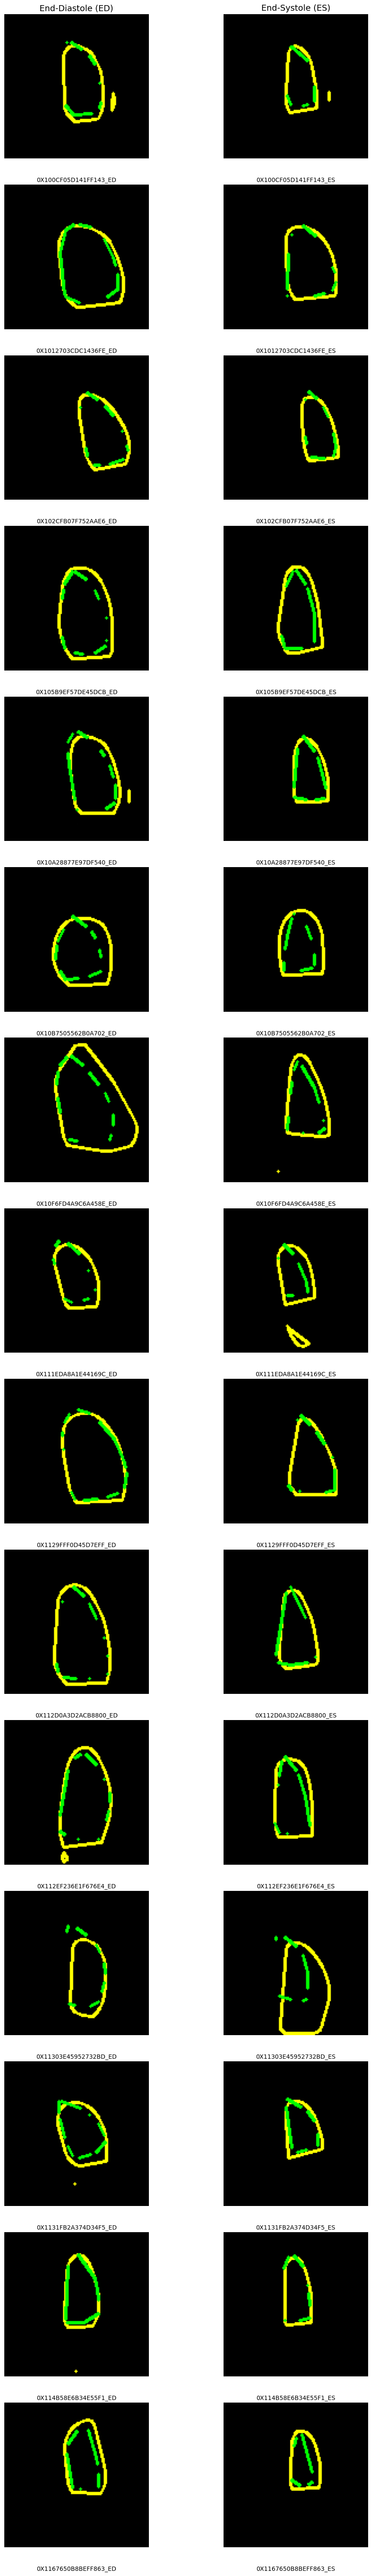

In [ ]:
# Install required libraries
!pip uninstall -y timm pretrained-backbones-unet
!pip install pretrained-backbones-unet --no-deps
!pip install timm==0.9.12
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model predicts 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names in VolumeTracings.csv
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data
grouped = vol_tracings_df.groupby("FileName")

# Updated colormap for predictions (focusing on LV, class 1)
pred_colors = {
    1: (255, 255, 0)  # LV (yellow)
}

# Colormap for ground truth (focusing on LV, class 1 mapped from 255)
gt_colors = {
    1: (0, 255, 0)    # LV (green)
}

def create_solid_contours(mask, class_colors, thickness=2, alpha=1):
    """Create solid contours for predictions."""
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)
    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=2, dash_length=2, gap_length=7, alpha=1):
    """Creates a uniform hashed pattern overlay with consistent spacing."""
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == 255 if c == 1 else mask == 0).astype(np.uint8)  # Map 255 to LV, 0 to background
        kernel = np.ones((3, 3), np.uint8)
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        for cnt in convex_contours:
            perimeter = cv2.arcLength(cnt, True)
            num_points = int(perimeter / (dash_length + gap_length))
            if num_points < 2:
                continue
            resampled_points = []
            for i in range(num_points):
                dist = (i * perimeter) / num_points
                idx = 0
                curr_dist = 0
                while curr_dist < dist and idx < len(cnt) - 1:
                    curr_dist += np.linalg.norm(cnt[idx + 1][0] - cnt[idx][0])
                    idx += 1
                resampled_points.append(cnt[idx][0])
            for i in range(0, len(resampled_points) - 1, 2):
                pt1 = tuple(resampled_points[i])
                pt2 = tuple(resampled_points[i + 1])
                cv2.line(mask_hashed, pt1, pt2, (*color, int(255 * alpha)), thickness)
    return mask_hashed

# Function to get ED and ES frames
def get_ed_es_frames(video_name):
    video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
    if video_data is None:
        print(f"No data for {video_name}")
        return None, None
    unique_frames = sorted(video_data["Frame"].unique())
    if len(unique_frames) != 2:
        print(f"Invalid frame count for {video_name}: {len(unique_frames)}")
        return None, None
    frame_areas = {}
    for frame_number in unique_frames:
        mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
        mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                lv_area = np.sum(mask == 255)
                frame_areas[frame_number] = lv_area
    if len(frame_areas) != 2:
        print(f"Missing areas for {video_name}")
        return None, None
    ed_frame = max(frame_areas, key=frame_areas.get)
    es_frame = min(frame_areas, key=frame_areas.get)
    print(f"ED: {ed_frame} (area: {frame_areas[ed_frame]}), ES: {es_frame} (area: {frame_areas[es_frame]}) for {video_name}")
    return ed_frame, es_frame

# Select first 15 test videos
selected_videos = test_videos[:15]

# Set up subplots
num_pairs = 15
fig, axs = plt.subplots(nrows=num_pairs, ncols=2, figsize=(12, num_pairs * 4))

model.eval()
with torch.no_grad():
    for i, video_name in enumerate(selected_videos):
        ed_frame, es_frame = get_ed_es_frames(video_name)
        if ed_frame is None or es_frame is None:
            axs[i, 0].axis("off")
            axs[i, 1].axis("off")
            continue

        for col, frame_number in enumerate([ed_frame, es_frame]):
            phase = "ED" if frame_number == ed_frame else "ES"

            # Load video frame
            video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
            video_frame = cv2.imread(video_frame_path, cv2.IMREAD_GRAYSCALE)
            if video_frame is None:
                print(f"Failed to load video frame: {video_frame_path}")
                axs[i, col].axis("off")
                continue
            video_frame = cv2.resize(video_frame, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST).astype(np.float32) / 255.0
            video_frame_rgb = np.stack([video_frame] * 3, axis=-1)  # Shape: (128, 128, 3)

            # Prepare input for model
            input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

            # Get model prediction
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]

            # Load ground truth mask
            mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
            mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                axs[i, col].axis("off")
                continue
            mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

            # Create edge overlays (focusing on LV, class 1)
            pred_solid = create_solid_contours(pred, pred_colors)
            gt_hashed = create_hashed_overlay(mask_resized, gt_colors)

            # Resize overlays to match original video frame size
            pred_solid = cv2.resize(pred_solid, (video_frame.shape[1], video_frame.shape[0]))
            gt_hashed = cv2.resize(gt_hashed, (video_frame.shape[1], video_frame.shape[0]))

            # Convert video frame to RGBA
            result = cv2.cvtColor(cv2.cvtColor(video_frame_rgb, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2BGRA)

            # Layer the edges: first predictions (solid), then ground truth (dashed)
            for overlay in [pred_solid, gt_hashed]:
                alpha = overlay[:, :, 3:4].astype(float) / 255
                result = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

            # Display result
            axs[i, col].imshow(result)
            axs[i, col].text(0.5, -0.15, f"{video_name}_{phase}", fontsize=10, ha='center', va='center', transform=axs[i, col].transAxes)
            axs[i, col].axis("off")

# Add column titles
axs[0, 0].set_title("End-Diastole (ED)", fontsize=14)
axs[0, 1].set_title("End-Systole (ES)", fontsize=14)

plt.tight_layout()
plt.show()

Found existing installation: timm 0.9.12
Uninstalling timm-0.9.12:
  Successfully uninstalled timm-0.9.12
Found existing installation: pretrained-backbones-unet 0.0.1
Uninstalling pretrained-backbones-unet-0.0.1:
  Successfully uninstalled pretrained-backbones-unet-0.0.1
  Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl (15 kB)


  Using cached timm-0.9.12-py3-none-any.whl.metadata (60 kB)
Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 0.9.12 which is incompatible.


timm version: 0.9.12
Unet imported successfully!
[Info] Google Drive is already mounted.
Successfully loaded model weights from best_model.pth.
Loading FileList.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv...
Successfully loaded FileList.csv.
Loading VolumeTracings.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Successfully loaded VolumeTracings.csv.
Found 1277 videos labeled as TEST in FileList.csv.
ED: 37 (area: 3345), ES: 52 (area: 1798) for 0X11DD5C8CC2A4D225
ED: 74 (area: 1878), ES: 92 (area: 1056) for 0X126C02C8B984672B
ED: 86 (area: 1288), ES: 100 (area: 737) for 0X126D2362E5A0A3E2
ED: 42 (area: 1319), ES: 59 (area: 837) for 0X127A2C51D192532D
ED: 66 (area: 2483), ES: 84 (area: 2149) for 0X129133A90A61A59D
ED: 49 (area: 1589), ES: 67 (area: 980) for 0X129ED481CEECBD9
ED: 44 (area: 754), ES: 55 (area: 439) for 0X132C1E8DBB715D1D
ED: 97 (area: 2780), ES: 113 (area: 1726) for 0X1335F88662E38FD5
ED: 93 (area: 768

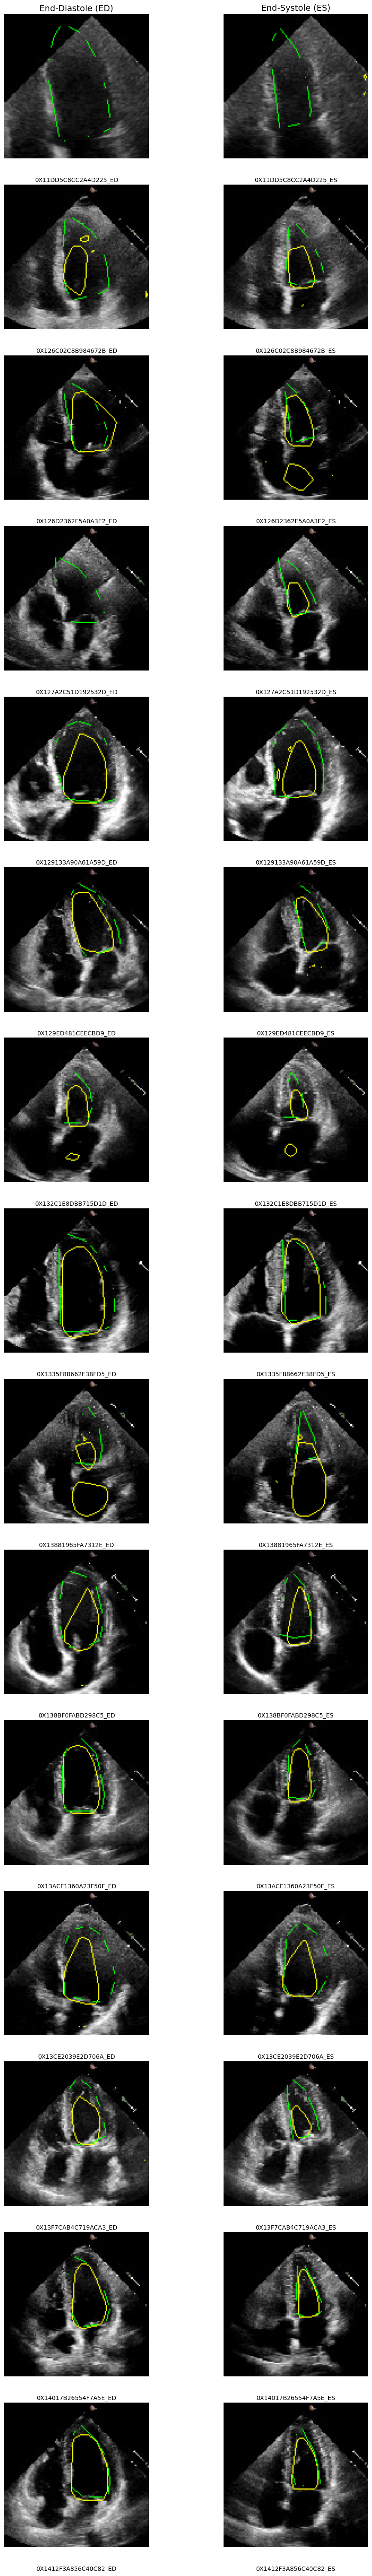

In [ ]:
# Install required libraries
!pip uninstall -y timm pretrained-backbones-unet
!pip install pretrained-backbones-unet --no-deps
!pip install timm==0.9.12
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model predicts 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names in VolumeTracings.csv
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data
grouped = vol_tracings_df.groupby("FileName")

# Updated colormap for predictions (focusing on LV, class 1)
pred_colors = {
    1: (255, 255, 0)  # LV (yellow)
}

# Colormap for ground truth (focusing on LV, class 1 mapped from 255)
gt_colors = {
    1: (0, 255, 0)    # LV (green)
}

def create_solid_contours(mask, class_colors, thickness=1, alpha=1):
    """Create solid contours for predictions."""
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)
    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=1, dash_length=2, gap_length=7, alpha=1):
    """Creates a uniform hashed pattern overlay with consistent spacing."""
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == 255 if c == 1 else mask == 0).astype(np.uint8)  # Map 255 to LV, 0 to background
        kernel = np.ones((3, 3), np.uint8)
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        for cnt in convex_contours:
            perimeter = cv2.arcLength(cnt, True)
            num_points = int(perimeter / (dash_length + gap_length))
            if num_points < 2:
                continue
            resampled_points = []
            for i in range(num_points):
                dist = (i * perimeter) / num_points
                idx = 0
                curr_dist = 0
                while curr_dist < dist and idx < len(cnt) - 1:
                    curr_dist += np.linalg.norm(cnt[idx + 1][0] - cnt[idx][0])
                    idx += 1
                resampled_points.append(cnt[idx][0])
            for i in range(0, len(resampled_points) - 1, 2):
                pt1 = tuple(resampled_points[i])
                pt2 = tuple(resampled_points[i + 1])
                cv2.line(mask_hashed, pt1, pt2, (*color, int(255 * alpha)), thickness)
    return mask_hashed

# Function to get ED and ES frames
def get_ed_es_frames(video_name):
    video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
    if video_data is None:
        print(f"No data for {video_name}")
        return None, None
    unique_frames = sorted(video_data["Frame"].unique())
    if len(unique_frames) != 2:
        print(f"Invalid frame count for {video_name}: {len(unique_frames)}")
        return None, None
    frame_areas = {}
    for frame_number in unique_frames:
        mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
        mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                lv_area = np.sum(mask == 255)
                frame_areas[frame_number] = lv_area
    if len(frame_areas) != 2:
        print(f"Missing areas for {video_name}")
        return None, None
    ed_frame = max(frame_areas, key=frame_areas.get)
    es_frame = min(frame_areas, key=frame_areas.get)
    print(f"ED: {ed_frame} (area: {frame_areas[ed_frame]}), ES: {es_frame} (area: {frame_areas[es_frame]}) for {video_name}")
    return ed_frame, es_frame

# Select second 15 test videos
selected_videos = test_videos[15:30]

# Set up subplots
num_pairs = 15
fig, axs = plt.subplots(nrows=num_pairs, ncols=2, figsize=(12, num_pairs * 4))

model.eval()
with torch.no_grad():
    for i, video_name in enumerate(selected_videos):
        ed_frame, es_frame = get_ed_es_frames(video_name)
        if ed_frame is None or es_frame is None:
            axs[i, 0].axis("off")
            axs[i, 1].axis("off")
            continue

        for col, frame_number in enumerate([ed_frame, es_frame]):
            phase = "ED" if frame_number == ed_frame else "ES"

            # Load original RGB video frame
            video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
            video_frame = cv2.imread(video_frame_path)
            if video_frame is None:
                print(f"Failed to load video frame: {video_frame_path}")
                axs[i, col].axis("off")
                continue
            video_frame = cv2.resize(video_frame, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
            video_frame_rgb = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

            # Prepare input for model (convert to 3-channel for consistency)
            input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

            # Get model prediction
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]

            # Load ground truth mask
            mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
            mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                axs[i, col].axis("off")
                continue
            mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

            # Create edge overlays (focusing on LV, class 1)
            pred_solid = create_solid_contours(pred, pred_colors)
            gt_hashed = create_hashed_overlay(mask_resized, gt_colors)

            # Resize overlays to match original video frame size
            pred_solid = cv2.resize(pred_solid, (video_frame.shape[1], video_frame.shape[0]))
            gt_hashed = cv2.resize(gt_hashed, (video_frame.shape[1], video_frame.shape[0]))

            # Convert original RGB image to RGBA
            result = cv2.cvtColor(video_frame_rgb, cv2.COLOR_RGB2RGBA)

            # Layer the edges: first predictions (solid), then ground truth (dashed)
            for overlay in [pred_solid, gt_hashed]:
                alpha = overlay[:, :, 3:4].astype(float) / 255
                result = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

            # Display result
            axs[i, col].imshow(result)
            axs[i, col].text(0.5, -0.15, f"{video_name}_{phase}", fontsize=10, ha='center', va='center', transform=axs[i, col].transAxes)
            axs[i, col].axis("off")

# Add column titles
axs[0, 0].set_title("End-Diastole (ED)", fontsize=14)
axs[0, 1].set_title("End-Systole (ES)", fontsize=14)

plt.tight_layout()
plt.show()

Found existing installation: timm 0.9.12
Uninstalling timm-0.9.12:
  Successfully uninstalled timm-0.9.12
Found existing installation: pretrained-backbones-unet 0.0.1
Uninstalling pretrained-backbones-unet-0.0.1:
  Successfully uninstalled pretrained-backbones-unet-0.0.1
  Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached pretrained_backbones_unet-0.0.1-py3-none-any.whl (15 kB)


  Using cached timm-0.9.12-py3-none-any.whl.metadata (60 kB)
Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 0.9.12 which is incompatible.


timm version: 0.9.12
Unet imported successfully!
[Info] Google Drive is already mounted.
Successfully loaded model weights from best_model.pth.
Loading FileList.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv...
Successfully loaded FileList.csv.
Loading VolumeTracings.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Successfully loaded VolumeTracings.csv.
Found 1277 videos labeled as TEST in FileList.csv.
ED: 37 (area: 3345), ES: 52 (area: 1798) for 0X11DD5C8CC2A4D225
ED: 74 (area: 1878), ES: 92 (area: 1056) for 0X126C02C8B984672B
ED: 86 (area: 1288), ES: 100 (area: 737) for 0X126D2362E5A0A3E2
ED: 42 (area: 1319), ES: 59 (area: 837) for 0X127A2C51D192532D
ED: 66 (area: 2483), ES: 84 (area: 2149) for 0X129133A90A61A59D
ED: 49 (area: 1589), ES: 67 (area: 980) for 0X129ED481CEECBD9
ED: 44 (area: 754), ES: 55 (area: 439) for 0X132C1E8DBB715D1D
ED: 97 (area: 2780), ES: 113 (area: 1726) for 0X1335F88662E38FD5
ED: 93 (area: 768

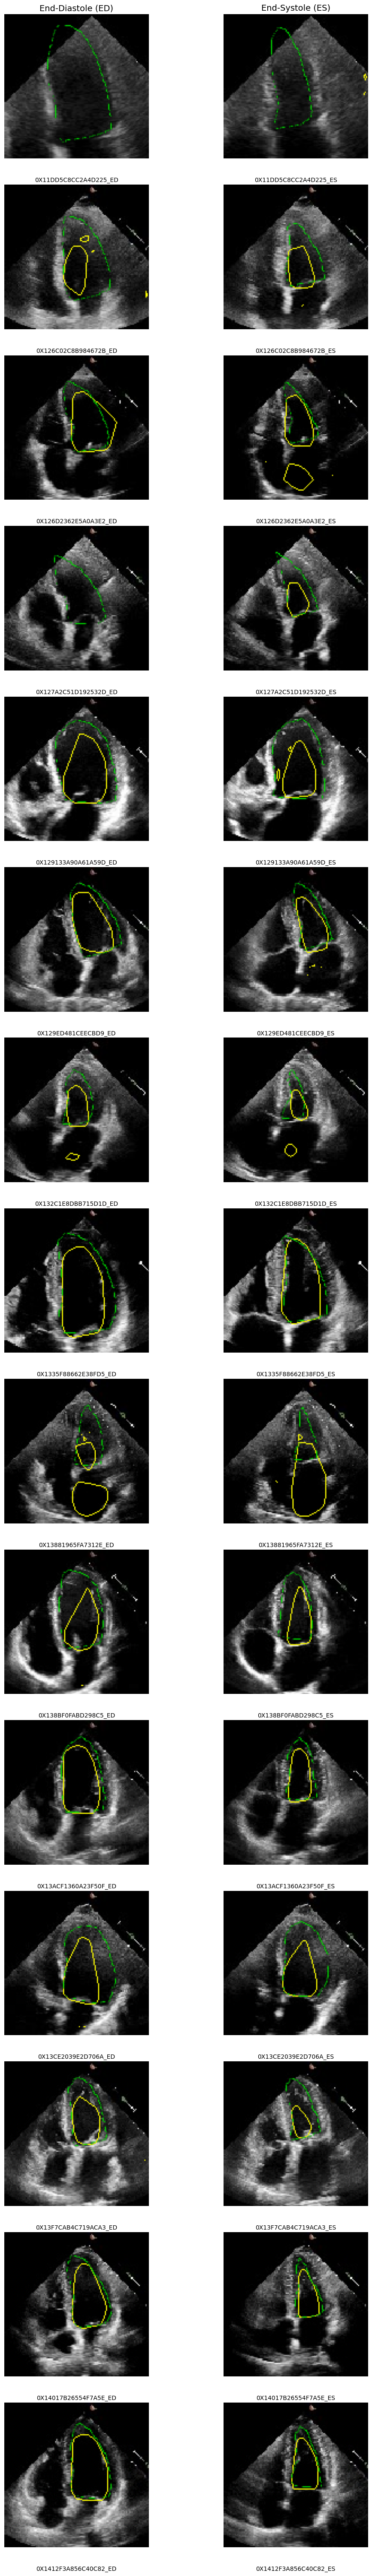

In [ ]:
# Install required libraries
!pip uninstall -y timm pretrained-backbones-unet
!pip install pretrained-backbones-unet --no-deps
!pip install timm==0.9.12
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model predicts 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names in VolumeTracings.csv
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data
grouped = vol_tracings_df.groupby("FileName")

# Updated colormap for predictions (focusing on LV, class 1)
pred_colors = {
    1: (255, 255, 0)  # LV (yellow)
}

# Colormap for ground truth (focusing on LV, class 1 mapped from 255)
gt_colors = {
    1: (0, 255, 0)    # LV (green)
}

def create_solid_contours(mask, class_colors, thickness=1, alpha=1):
    """Create solid contours for predictions."""
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)
    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=1, dash_length=10, gap_length=5, alpha=1, epsilon_factor=0.0005):
    """Creates a uniform hashed pattern overlay with approxPolyDP."""
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == 255 if c == 1 else mask == 0).astype(np.uint8)  # Map 255 to LV, 0 to background
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            epsilon = epsilon_factor * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            for i in range(len(approx)):
                start = tuple(approx[i][0])
                end = tuple(approx[(i + 1) % len(approx)][0])
                line_length = np.linalg.norm(np.array(end) - np.array(start))
                num_dashes = max(1, int(line_length // (dash_length + gap_length)))
                for j in range(num_dashes):
                    t1 = j / num_dashes
                    t2 = (j + 0.5) / num_dashes
                    dash_start = tuple(((1 - t1) * np.array(start) + t1 * np.array(end)).astype(int))
                    dash_end = tuple(((1 - t2) * np.array(start) + t2 * np.array(end)).astype(int))
                    cv2.line(mask_hashed, dash_start, dash_end, (*color, int(255 * alpha)), thickness, lineType=cv2.LINE_AA)
    return mask_hashed

# Function to get ED and ES frames
def get_ed_es_frames(video_name):
    video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
    if video_data is None:
        print(f"No data for {video_name}")
        return None, None
    unique_frames = sorted(video_data["Frame"].unique())
    if len(unique_frames) != 2:
        print(f"Invalid frame count for {video_name}: {len(unique_frames)}")
        return None, None
    frame_areas = {}
    for frame_number in unique_frames:
        mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
        mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                lv_area = np.sum(mask == 255)
                frame_areas[frame_number] = lv_area
    if len(frame_areas) != 2:
        print(f"Missing areas for {video_name}")
        return None, None
    ed_frame = max(frame_areas, key=frame_areas.get)
    es_frame = min(frame_areas, key=frame_areas.get)
    print(f"ED: {ed_frame} (area: {frame_areas[ed_frame]}), ES: {es_frame} (area: {frame_areas[es_frame]}) for {video_name}")
    return ed_frame, es_frame

# Select second 15 test videos
selected_videos = test_videos[15:30]

# Set up subplots
num_pairs = 15
fig, axs = plt.subplots(nrows=num_pairs, ncols=2, figsize=(12, num_pairs * 4))

model.eval()
with torch.no_grad():
    for i, video_name in enumerate(selected_videos):
        ed_frame, es_frame = get_ed_es_frames(video_name)
        if ed_frame is None or es_frame is None:
            axs[i, 0].axis("off")
            axs[i, 1].axis("off")
            continue

        for col, frame_number in enumerate([ed_frame, es_frame]):
            phase = "ED" if frame_number == ed_frame else "ES"

            # Load original RGB video frame
            video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
            video_frame = cv2.imread(video_frame_path)
            if video_frame is None:
                print(f"Failed to load video frame: {video_frame_path}")
                axs[i, col].axis("off")
                continue
            video_frame = cv2.resize(video_frame, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
            video_frame_rgb = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

            # Prepare input for model (convert to 3-channel for consistency)
            input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

            # Get model prediction
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]

            # Load ground truth mask
            mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
            mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                axs[i, col].axis("off")
                continue
            mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

            # Create edge overlays (focusing on LV, class 1)
            pred_solid = create_solid_contours(pred, pred_colors)
            gt_hashed = create_hashed_overlay(mask_resized, gt_colors)

            # Resize overlays to match original video frame size
            pred_solid = cv2.resize(pred_solid, (video_frame.shape[1], video_frame.shape[0]))
            gt_hashed = cv2.resize(gt_hashed, (video_frame.shape[1], video_frame.shape[0]))

            # Convert original RGB image to RGBA
            result = cv2.cvtColor(video_frame_rgb, cv2.COLOR_RGB2RGBA)

            # Layer the edges: first predictions (solid), then ground truth (dashed)
            for overlay in [pred_solid, gt_hashed]:
                alpha = overlay[:, :, 3:4].astype(float) / 255
                result = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

            # Display result
            axs[i, col].imshow(result)
            axs[i, col].text(0.5, -0.15, f"{video_name}_{phase}", fontsize=10, ha='center', va='center', transform=axs[i, col].transAxes)
            axs[i, col].axis("off")

# Add column titles
axs[0, 0].set_title("End-Diastole (ED)", fontsize=14)
axs[0, 1].set_title("End-Systole (ES)", fontsize=14)

plt.tight_layout()
plt.show()

Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Successfully loaded model weights from best_model.pth.
Loading FileList.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv...
Successfully loaded FileList.csv.
Loading VolumeTracings.csv from /content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv...
Successfully loaded VolumeTracings.csv.
Found 1277 videos labeled as TEST in FileList.csv.
ED: 37 (area: 3345), ES: 52 (area: 1798) for 0X11DD5C8CC2A4D225
ED: 74 (area: 1878), ES: 92 (area: 1056) for 0X126C02C8B984672B
ED: 86 (area: 1288), ES: 100 (area: 737) for 0X126D2362E5A0A3E2
ED: 42 (area: 1319), ES: 59 (area: 837) for 0X127A2C51D192532D
ED: 66 (area: 2483), ES: 84 (area: 2149) for 0X129133A90A61A59D
ED: 49 (area: 1589), ES: 67 (area: 980) for 0X129ED481CEECBD9
ED: 44 (area: 754), ES: 55 (area: 439) for 0X132C1E8DBB715D1D
ED: 97 (area: 2780), ES: 113 (area: 1726) for 0X1335F88662E38FD5
ED: 93 (area: 768), ES: 105 (area: 469) for 0X13881965FA7312E
ED: 175 (area: 1794), ES: 194 (area: 1122) f

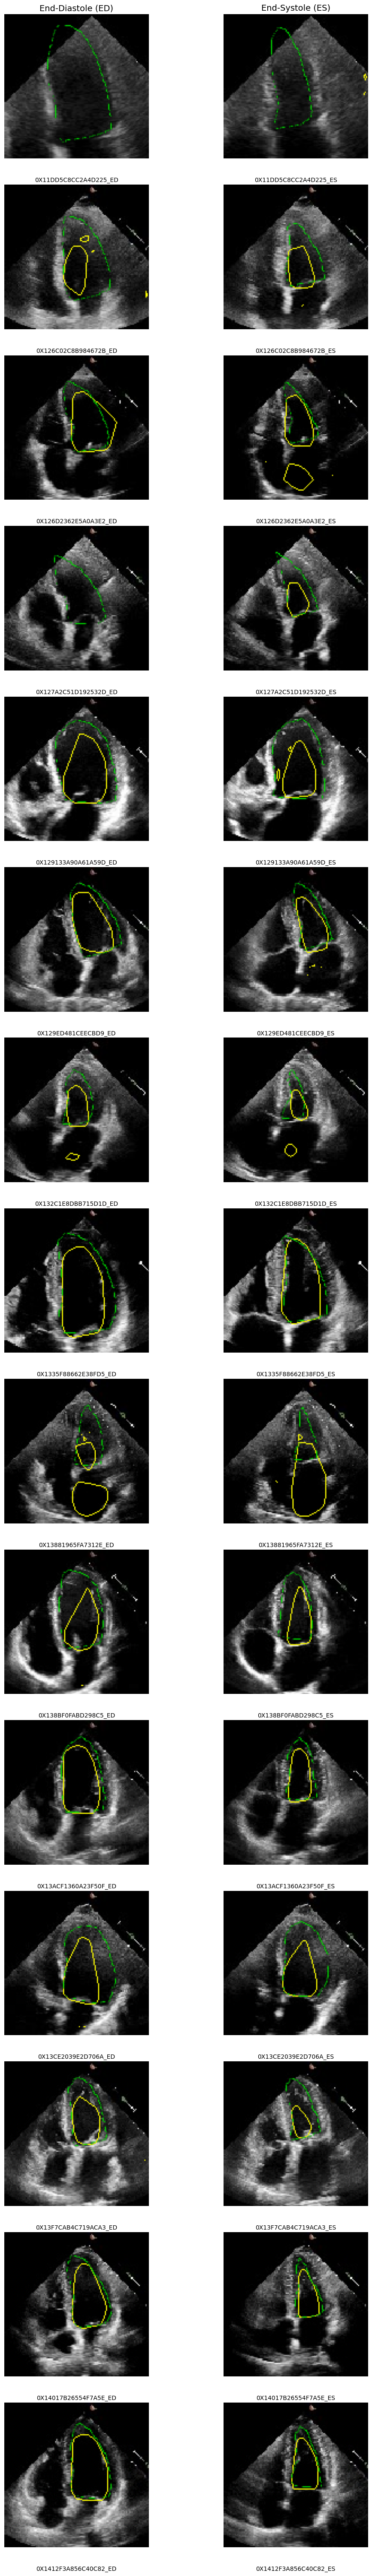

In [ ]:
# Install required libraries
!pip uninstall -y timm pretrained-backbones-unet
!pip install pretrained-backbones-unet --no-deps
!pip install timm==0.9.12
import timm
print(f"timm version: {timm.__version__}")
from backbones_unet.model.unet import Unet
print("Unet imported successfully!")

import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    print("[Info] Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("[Info] Google Drive is already mounted.")

# Constants
NUM_CLASSES = 4  # Model predicts 4 classes (background, LV, Myocardium, LA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_TRACINGS_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/MaskTracings"
VIDEO_FRAMES_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VideoFrames"
FILELIST_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/FileList.csv"
VOL_TRACINGS_CSV_PATH = "/content/drive/MyDrive/EchoNet_Dataset/EchoNet-Dynamic/VolumeTracings.csv"
MODEL_PATH = "/content/drive/MyDrive/✨ GP ✨/best_model.pth"
IMAGE_SIZE = (128, 128)

# Instantiate the model
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Load the trained model weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Successfully loaded model weights from best_model.pth.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
    raise

# Load the CSV files
print(f"Loading FileList.csv from {FILELIST_CSV_PATH}...")
try:
    filelist_df = pd.read_csv(FILELIST_CSV_PATH)
    print("Successfully loaded FileList.csv.")
except Exception as e:
    print(f"Failed to load FileList.csv: {e}")
    raise

print(f"Loading VolumeTracings.csv from {VOL_TRACINGS_CSV_PATH}...")
try:
    vol_tracings_df = pd.read_csv(VOL_TRACINGS_CSV_PATH)
    print("Successfully loaded VolumeTracings.csv.")
except Exception as e:
    print(f"Failed to load VolumeTracings.csv: {e}")
    raise

# Filter for TEST videos
test_videos = filelist_df[filelist_df['Split'].str.upper() == 'TEST']['FileName'].unique()
print(f"Found {len(test_videos)} videos labeled as TEST in FileList.csv.")

# Clean video names in VolumeTracings.csv
vol_tracings_df['FileName'] = vol_tracings_df['FileName'].str.replace('.avi', '')

# Group VolumeTracings data
grouped = vol_tracings_df.groupby("FileName")

# Updated colormap for predictions (focusing on LV, class 1)
pred_colors = {
    1: (255, 255, 0)  # LV (yellow)
}

# Colormap for ground truth (focusing on LV, class 1 mapped from 255)
gt_colors = {
    1: (0, 255, 0)    # LV (green)
}

def create_solid_contours(mask, class_colors, thickness=1, alpha=1):
    """Create solid contours for predictions."""
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)
    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=1, dash_length=10, gap_length=5, alpha=1, epsilon_factor=0.0005):
    """Creates a uniform hashed pattern overlay with approxPolyDP."""
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == 255 if c == 1 else mask == 0).astype(np.uint8)  # Map 255 to LV, 0 to background
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            epsilon = epsilon_factor * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            for i in range(len(approx)):
                start = tuple(approx[i][0])
                end = tuple(approx[(i + 1) % len(approx)][0])
                line_length = np.linalg.norm(np.array(end) - np.array(start))
                num_dashes = max(1, int(line_length // (dash_length + gap_length)))
                for j in range(num_dashes):
                    t1 = j / num_dashes
                    t2 = (j + 0.5) / num_dashes
                    dash_start = tuple(((1 - t1) * np.array(start) + t1 * np.array(end)).astype(int))
                    dash_end = tuple(((1 - t2) * np.array(start) + t2 * np.array(end)).astype(int))
                    cv2.line(mask_hashed, dash_start, dash_end, (*color, int(255 * alpha)), thickness, lineType=cv2.LINE_AA)
    return mask_hashed

# Function to get ED and ES frames
def get_ed_es_frames(video_name):
    video_data = grouped.get_group(video_name) if video_name in grouped.groups else None
    if video_data is None:
        print(f"No data for {video_name}")
        return None, None
    unique_frames = sorted(video_data["Frame"].unique())
    if len(unique_frames) != 2:
        print(f"Invalid frame count for {video_name}: {len(unique_frames)}")
        return None, None
    frame_areas = {}
    for frame_number in unique_frames:
        mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
        mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                lv_area = np.sum(mask == 255)
                frame_areas[frame_number] = lv_area
    if len(frame_areas) != 2:
        print(f"Missing areas for {video_name}")
        return None, None
    ed_frame = max(frame_areas, key=frame_areas.get)
    es_frame = min(frame_areas, key=frame_areas.get)
    print(f"ED: {ed_frame} (area: {frame_areas[ed_frame]}), ES: {es_frame} (area: {frame_areas[es_frame]}) for {video_name}")
    return ed_frame, es_frame

# Select second 15 test videos
selected_videos = test_videos[15:30]

# Set up subplots
num_pairs = 15
fig, axs = plt.subplots(nrows=num_pairs, ncols=2, figsize=(12, num_pairs * 4))

model.eval()
with torch.no_grad():
    for i, video_name in enumerate(selected_videos):
        ed_frame, es_frame = get_ed_es_frames(video_name)
        if ed_frame is None or es_frame is None:
            axs[i, 0].axis("off")
            axs[i, 1].axis("off")
            continue

        for col, frame_number in enumerate([ed_frame, es_frame]):
            phase = "ED" if frame_number == ed_frame else "ES"

            # Load original RGB video frame
            video_frame_path = os.path.join(VIDEO_FRAMES_PATH, video_name, f"{video_name}_frame_{str(frame_number).zfill(4)}.jpg")
            video_frame = cv2.imread(video_frame_path)
            if video_frame is None:
                print(f"Failed to load video frame: {video_frame_path}")
                axs[i, col].axis("off")
                continue
            video_frame = cv2.resize(video_frame, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
            video_frame_rgb = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

            # Prepare input for model (convert to 3-channel for consistency)
            input_tensor = torch.from_numpy(video_frame_rgb).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

            # Get model prediction
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]

            # Load ground truth mask
            mask_file = f"{video_name}_frame_{str(frame_number).zfill(4)}_segments.png"
            mask_path = os.path.join(MASK_TRACINGS_PATH, video_name, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                axs[i, col].axis("off")
                continue
            mask_resized = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

            # Create edge overlays (focusing on LV, class 1)
            pred_solid = create_solid_contours(pred, pred_colors)
            gt_hashed = create_hashed_overlay(mask_resized, gt_colors)

            # Resize overlays to match original video frame size
            pred_solid = cv2.resize(pred_solid, (video_frame.shape[1], video_frame.shape[0]))
            gt_hashed = cv2.resize(gt_hashed, (video_frame.shape[1], video_frame.shape[0]))

            # Convert original RGB image to RGBA
            result = cv2.cvtColor(video_frame_rgb, cv2.COLOR_RGB2RGBA)

            # Layer the edges: first predictions (solid), then ground truth (dashed)
            for overlay in [pred_solid, gt_hashed]:
                alpha = overlay[:, :, 3:4].astype(float) / 255
                result = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

            # Display result
            axs[i, col].imshow(result)
            axs[i, col].text(0.5, -0.15, f"{video_name}_{phase}", fontsize=10, ha='center', va='center', transform=axs[i, col].transAxes)
            axs[i, col].axis("off")

# Add column titles
axs[0, 0].set_title("End-Diastole (ED)", fontsize=14)
axs[0, 1].set_title("End-Systole (ES)", fontsize=14)

plt.tight_layout()
plt.show()